# XGBoost Hyperparameter-Tuning with Ray Tune

This notebook demonstrates how a XGBoost Classifier (using the Sklearn-API) can be tuned with **Ray Tune**.

We will use the Optuna Search Algorithm and the ASHA Scheduler for aggressive early stopping of bad trials.

* [Data Loading and Preprocessing](#loading-preprocessing)
* [Model Training and Hyperparameter-Optimization](#training-optim)
    - [Step 1: Define the parameter space](#parameter-space)
    - [Step 2: Define the objective function](#objective)
    - [Step 3: Define Search Algorithm and Scheduler](#search-scheduler)
    - [Step 4: Define the Tuner object and run the optimization](#tune)
    - [Step 5: Evaluate the results](#evaluate)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.xgboost import TuneReportCallback
from ray.tune.search.optuna import OptunaSearch
import matplotlib.pyplot as plt

<a id="loading-preprocessing"></a>
# Data Loading and Preprocessing

In [2]:
# Original dataset
wines = pd.read_csv("../data/winequality-red.csv")
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [3]:
target = "quality"

X = wines.drop(columns=target)
y = wines[target]
y -= 3

# apply standard scaling
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

y = y.astype("long")
X = X.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("Train samples: ", X_train.shape[0])
print("Test samples: ", X_test.shape[0])

Train samples:  1279
Test samples:  320


<a id="training-optim"></a>
# Model Training and Hyperparameter Optimization

We will now train a `XGBClassifier` and tune its hyperparameters with ray tune.


1. Define the Parameter Space
2. Define the objective
2. Define Search Algorithm and Scheduler
4. Define a Tuner Object
5. Evaluate Results

<a id="parameter-space"></a>
## Step 1: Define Parameter Space

We define the parameter space using the functions provided by tune:

For example:
- A random integer in a given interval (discrete uniform distribution) can be specified with `tune.randint(low, high)`
- A random float in a given interval (continuous uniform distribution) can be specified with `tune.uniform(low, high)`

For more information, see here: https://docs.ray.io/en/latest/tune/api/search_space.html

In [4]:
param_space = {
    "objective": "multi:softprob",
    "tree_method": "hist",
    "early_stopping_rounds": 20,
    "eval_metric": "mlogloss",  # mlogloss is the multi-class negative log-likelihood
    "n_estimators": tune.randint(200, 600),
    "gamma": tune.randint(1, 5),
    "max_depth": tune.randint(2, 9),
    "min_child_weight": tune.randint(1, 5),
    "subsample": tune.uniform(0.5, 1.0),
    "eta": tune.loguniform(1e-4, 1e-1),
    "colsample_bytree": tune.uniform(0.5, 1),
}

<a id="objective"></a>
## Step 2: Define the objective function

This function trains a single classifier and takes in a `config`.
It also reports the metrics to the Tuner.

In [5]:
def objective(config):
    """Objective to be optimized.

    Uses a simple 0.8/0.2 train-validation-split and logs the validation logloss using the `TuneReportCallback`.

    Parameters
    ----------
    config: dict
        The config object.
    """
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, stratify=y_train, shuffle=True, test_size=0.2
    )
    trc = TuneReportCallback({"loss": "validation_0-mlogloss"})
    clf = XGBClassifier(**config, callbacks=[trc]).fit(
        X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=False
    )

<a id="search-scheduler"></a>
## Step 3: Search Algorithm and Scheduler

We will use Optuna's Search Algorithm, combined with the ASHA Scheduler.

Note that with Ray Tune, it is really easy to switch out both of them. Ray Tune supports many more search algorithms (see https://docs.ray.io/en/latest/tune/api/suggestion.html)

In [6]:
scheduler = ASHAScheduler(grace_period=10, reduction_factor=3)

search_alg = OptunaSearch()

<a id="tune"></a>
## Step 4: Define the Tuner object and run the optimization

We specify the objective, the parameter space and addionitional parameters via the `tune.TuneConfig`.

We can specify how many samples the tuning should use. Here we also specify the scheduler and the search algorithm.

In this example, we use `num_samples=500`, e.g. 500 trials will be executed. This takes approx. 300s (or 5min)

In [7]:
tuner = tune.Tuner(
    objective,
    param_space=param_space,
    tune_config=tune.TuneConfig(
        num_samples=500,
        metric="loss",
        mode="min",
        scheduler=scheduler,
        search_alg=search_alg,
    ),
)
results = tuner.fit()

2023-03-23 21:18:59,797	INFO worker.py:1553 -- Started a local Ray instance.
/Users/moritzmistol/Programming/Ray-Tune-XGBoost/.venv/lib/python3.10/site-packages/ray/tune/search/optuna/optuna_search.py:683: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  return ot.distributions.IntUniformDistribution(
/Users/moritzmistol/Programming/Ray-Tune-XGBoost/.venv/lib/python3.10/site-packages/ray/tune/search/optuna/optuna_search.py:671: FutureWarning: UniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  return ot.distributions.UniformDistribution(
/Users/moritzmistol/Programming/Ray-Tune-XGBoost/.venv/lib/python3.10/site-packages/ray/tune/search/optuna/optuna_s

/Users/moritzmistol/Programming/Ray-Tune-XGBoost/.venv/lib/python3.10/site-packages/optuna/distributions.py:799: FutureWarning: IntUniformDistribution(high=599, low=200, step=1) is deprecated and internally converted to IntDistribution(high=599, log=False, low=200, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/moritzmistol/Programming/Ray-Tune-XGBoost/.venv/lib/python3.10/site-packages/optuna/distributions.py:799: FutureWarning: IntUniformDistribution(high=4, low=1, step=1) is deprecated and internally converted to IntDistribution(high=4, log=False, low=1, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/Users/moritzmistol/Programming/Ray-Tune-XGBoost/.venv/lib/python3.10/site-packages/optuna/distributions.py:799: FutureWarning: IntUniformDistribution(high=8, low=2, step=1) is deprecated and internally converted to IntDistribution(high=8, log=False, low=2, step=1). See https:/

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_309067f4,2023-03-23_21-19-04,False,,a24e73fb62004e99945c6a22c0af17f2,MacMoritz.local,1,1.78191,127.0.0.1,22699,0.00392389,0.00392389,0.00392389,1679602744,0,,1,309067f4,0.00250506
objective_f7b3c2c5,2023-03-23_21-19-04,True,,a24e73fb62004e99945c6a22c0af17f2,MacMoritz.local,100,1.13515,127.0.0.1,22699,1.12765,0.0252709,1.12765,1679602744,0,,100,f7b3c2c5,0.00250506


2023-03-23 21:20:22,347	INFO tune.py:798 -- Total run time: 80.36 seconds (80.22 seconds for the tuning loop).


<a id="evaluate"></a>
## Step 5: Evaluate the results of the optimization

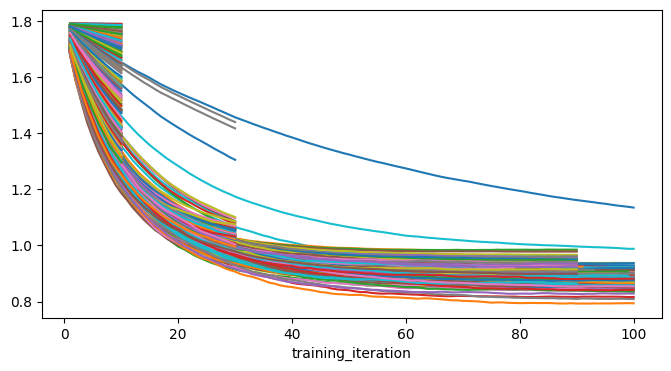

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
for result in results:
    result.metrics_dataframe.plot("training_iteration", "loss", ax=ax, legend=None)

Notice how a lot of bad performing trials get stopped early on by the ASHA Scheduler. This allows for efficient search on a lot of samples.

In [9]:
best_params = results.get_best_result("loss", mode="min").config
best_params

{'objective': 'multi:softprob',
 'tree_method': 'hist',
 'early_stopping_rounds': 20,
 'eval_metric': 'mlogloss',
 'n_estimators': 238,
 'gamma': 1,
 'max_depth': 7,
 'min_child_weight': 2,
 'subsample': 0.6326227451412804,
 'eta': 0.08963305218502629,
 'colsample_bytree': 0.68662604387161}

### Finally: Train the classifier on the full training data with best parameter config

In [10]:
clf = XGBClassifier(**best_params).fit(
    X_train, y_train, eval_set=[(X_test, y_test)], verbose=50
)

[0]	validation_0-mlogloss:1.69010
[50]	validation_0-mlogloss:0.80903
[100]	validation_0-mlogloss:0.77846
[126]	validation_0-mlogloss:0.78363


In [14]:
clf.score(X_test, y_test)

0.7